Idea!
Icons zijn de retailers
Orderd by producten die ze verkopen (maybe productcategoriesn getallen toeweizen?)
Groepen gemaakt op Retailer categorie

Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import pyodbc
import sqlite3
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler



Gather data

In [14]:
def getDbAsDF(conn: sqlite3.Connection, sql: str):
    cursor = conn.cursor()
    cursor.execute(sql)
    data = cursor.fetchall()

    columns = [column[0] for column in cursor.description]

    formatted_data = {}

    for i in range(len(columns)):
        dataList = []
        for j in data:
            dataList.append(j[i])
        formatted_data[columns[i]] = dataList

    df = pd.DataFrame(data=formatted_data, columns=columns)
    return df


# Connect to SQLite database
connection = sqlite3.connect(r'..\..\Data\merged.sqlite')

SQL = r"""
SELECT *
FROM order_header as OH
INNER JOIN retailer as RT ON OH.RETAILER_NAME = RT.COMPANY_NAME
INNER JOIN sales_demographic as SD on RT.RETAILER_CODEMR = SD.RETAILER_CODEMR
INNER JOIN order_details as OD ON OH.ORDER_NUMBER = OD.ORDER_NUMBER
INNER JOIN product as P ON P.PRODUCT_NUMBER = OD.PRODUCT_NUMBER
INNER JOIN product_type as PT ON PT.PRODUCT_TYPE_CODE = P.PRODUCT_TYPE_CODE
"""

DF = getDbAsDF(connection, SQL)
print(DF.columns)

DF[["UNIT_PRICE"]] = DF[["UNIT_PRICE"]].astype(float)
DF[["QUANTITY"]] = DF[["QUANTITY"]].astype(int)
DF

Index(['ORDER_NUMBER', 'RETAILER_NAME', 'RETAILER_SITE_CODE',
       'RETAILER_CONTACT_CODE', 'SALES_STAFF_CODE', 'SALES_BRANCH_CODE',
       'ORDER_DATE', 'ORDER_METHOD_CODE', 'RETAILER_CODE', 'RETAILER_CODEMR',
       'COMPANY_NAME', 'RETAILER_TYPE_CODE', 'DEMOGRAPHIC_CODE',
       'RETAILER_CODEMR', 'AGE_GROUP_CODE', 'SALES_PERCENT',
       'ORDER_DETAIL_CODE', 'ORDER_NUMBER', 'PRODUCT_NUMBER', 'QUANTITY',
       'UNIT_COST', 'UNIT_PRICE', 'UNIT_SALE_PRICE', 'PRODUCT_NUMBER',
       'INTRODUCTION_DATE', 'PRODUCT_TYPE_CODE', 'PRODUCTION_COST', 'MARGIN',
       'PRODUCT_IMAGE', 'LANGUAGE', 'PRODUCT_NAME', 'DESCRIPTION',
       'PRODUCT_TYPE_CODE', 'PRODUCT_LINE_CODE', 'PRODUCT_TYPE_EN'],
      dtype='object')


,ORDER_NUMBER,RETAILER_NAME,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE,RETAILER_CODE,RETAILER_CODEMR,...,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,PRODUCT_IMAGE,LANGUAGE,PRODUCT_NAME,DESCRIPTION,PRODUCT_TYPE_CODE,PRODUCT_LINE_CODE,PRODUCT_TYPE_EN
0,1831,Sport & Freizeit,36,52,15,13,2022-11-11 00:00:00,4,48,24,...,10,30,.33,P63PA3WT10.jpg,EN,Mountain Man Analog,"Padded leather strap, precision Swiss quartz m...",10,3,Watches
1,1831,Sport & Freizeit,36,52,15,13,2022-11-11 00:00:00,4,48,24,...,11,46.15,.23,P68PA3EW11.jpg,EN,Polar Sun,The Polar Sun sunglasses have 3 mm thick lense...,11,3,Eyewear
2,1831,Sport & Freizeit,36,52,15,13,2022-11-11 00:00:00,4,48,24,...,11,60,.33,P71PA3EW11.jpg,EN,Polar Wave,Acrylex lenses in the Polar Wave sunglasses ab...,11,3,Eyewear
3,1831,Sport & Freizeit,36,52,15,13,2022-11-11 00:00:00,4,48,24,...,13,79.19,.2,P78PA3BN13.jpg,EN,Seeker 35,This 7 x 35 model is economical and performs w...,13,3,Binoculars
4,1831,Sport & Freizeit,36,52,15,13,2022-11-11 00:00:00,4,48,24,...,10,30,.33,P63PA3WT10.jpg,EN,Mountain Man Analog,"Padded leather strap, precision Swiss quartz m...",10,3,Watches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192654,9242,"Chen Yu Enterprise Co.,",363,354,104,33,2022-10-07 00:00:00,2,172,575,...,13,79.19,.2,P78PA3BN13.jpg,EN,Seeker 35,This 7 x 35 model is economical and performs w...,13,3,Binoculars
192655,9242,"Chen Yu Enterprise Co.,",363,354,104,33,2022-10-07 00:00:00,2,172,575,...,14,20,.33,P82PA3NV14.jpg,EN,Glacier Basic,Traditional magnetic compass in a stainless st...,14,3,Navigation
192656,9242,"Chen Yu Enterprise Co.,",363,354,104,33,2022-10-07 00:00:00,2,172,575,...,16,2,.6,P91OP4SS16.jpg,EN,Sun Shelter 30,SPF 30 provides maximum protection and is long...,16,4,Sunscreen
192657,9242,"Chen Yu Enterprise Co.,",363,354,104,33,2022-10-07 00:00:00,2,172,575,...,17,16.43,.28,P96OP4FA17.jpg,EN,Compact Relief Kit,A personal first aid kit is recommended for ev...,17,4,First Aid


Selecting Data

In [29]:
Retailers = DF["RETAILER_CODE"].unique()
dataset = pd.DataFrame(columns=["Quantity","Totaalprijs","Retailer"])
for number in Retailers:
    quantity = 0
    price = 0
    list1 = []
    list2 = []
    FoundRows = DF.loc[DF['RETAILER_CODE'] == number]
    #Yes this works, no I cannot wrap my head arround dataframes.
    for row in FoundRows["QUANTITY"]:
        quantity += row
        list1.append(row)
    for row in FoundRows["UNIT_PRICE"]:
        list2.append(row)
    for i in range(len(list1)):
        price+=list1[i]*list2[i]

    dataset.loc[len(dataset)] = {"Retailer":number,"Quantity":quantity,"Totaalprijs":price}

print(dataset.sort_values(by=['Totaalprijs'], ascending=False))


# Data = DF[["RETAILER_CODE","UNIT_PRICE","QUANTITY","AGE_GROUP_CODE"]]

# Data = Data.T.drop_duplicates().T
# Data.dropna(inplace = True)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset)
scaled_features

    Quantity   Totaalprijs Retailer
17   1058022  1.033753e+08       95
6     567968  4.673710e+07       54
50    583692  4.304131e+07      160
15    336330  3.805562e+07       92
37    320340  3.271137e+07      104
..       ...           ...      ...
3      10336  1.075563e+06       57
4       6608  5.723819e+05       58
54      4020  4.656847e+05      131
27      3828  3.148885e+05      111
29      3088  2.826583e+05      105

[75 rows x 3 columns]


array([[ 0.36224896,  0.12452587, -1.63461937],
       [ 0.71319003,  0.62411206, -1.59003074],
       [-0.15560207, -0.23950235, -1.65691369],
       [-0.76780608, -0.72327569, -1.43397051],
       [-0.79026477, -0.75776108, -1.4116762 ],
       [-0.67630863, -0.17719811, -1.61232506],
       [ 2.59155066,  2.40612558, -1.50085347],
       [-0.7372989 , -0.43839778, -2.37033186],
       [-0.03985067, -0.23709114, -1.99132846],
       [ 1.12910947,  0.6569328 , -1.9244455 ],
       [-0.08192456,  0.08503928,  0.08204309],
       [-0.29128193, -0.353784  , -2.19197732],
       [ 0.53985813,  0.54372196, -1.87985687],
       [-0.7569864 , -0.68502379,  0.12663172],
       [-0.02741646, -0.31144501,  0.14892604],
       [ 1.19608792,  1.81114238, -0.65366939],
       [-0.79169856, -0.67425906, -0.63137508],
       [ 5.54379553,  6.28780811, -0.58678644],
       [ 0.61887319,  0.87271323, -0.56449212],
       [-0.19216972, -0.04423099, -0.54219781],
       [-0.5309055 , -0.52307159, -0.720

Clustering

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


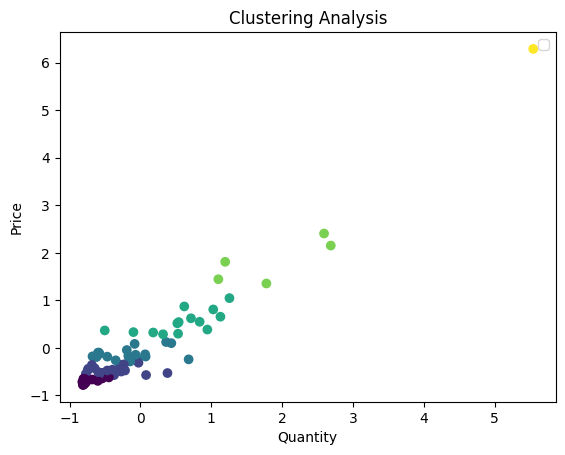

In [36]:

kmeans = KMeans(n_clusters=6, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)

y_km = kmeans.fit(dataset)
cluster_labels = kmeans.labels_

plt.scatter(scaled_features[:,0], scaled_features[:,1], c=cluster_labels)
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Clustering Analysis')
plt.grid
plt.legend()
plt.show()

Calculate distortion

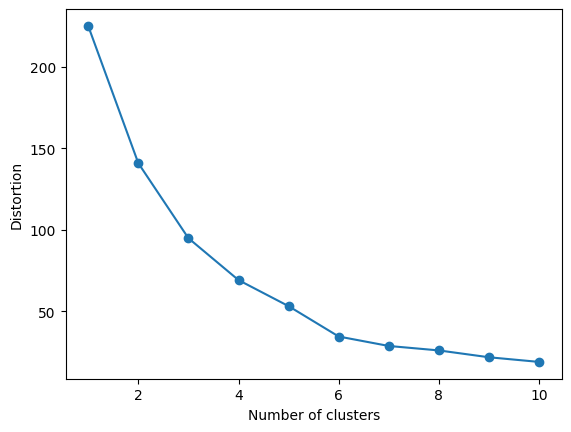

In [20]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(scaled_features)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()